In [1]:
import os
import sys
mrgan_lib_path = os.path.abspath('../')
if mrgan_lib_path not in sys.path:
    sys.path.insert(0, mrgan_lib_path)

In [2]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from fid.inception import InceptionV3
from build_dataset_fid_stats import get_activations, get_stats
from fid.fid_score import calculate_frechet_distance
from wgan_gp import Generator
from wgan_gp_mrr import GeneratorMRRSampler
from utils import mask_gpu

In [3]:
mask_gpu()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def config_gs(mrr, load_gen_path, batch_size=64, latent_dim=128, n_channels=3, wrt='train'):
    with np.load(f'../cifar10-{wrt}.npz') as f:
        real_features_train = f['features'][:]

    # Initialize generator and discriminator
    generator = Generator(latent_dim=latent_dim, n_channels=n_channels).to(device=device)
    generator.load_state_dict(torch.load(load_gen_path))
    generator.eval()
    gs = GeneratorMRRSampler(generator, mrr, latent_dim, device,
                             real_features_train, bsize=batch_size)
    return gs

def test(gs, n_samples=10000, wrt='test'):
    with np.load(f'../cifar10-{wrt}.npz') as f:
        real_mu_test = f['mu'][:]
        real_std_test = f['sigma'][:]
        
    with torch.no_grad():
        fake_features_tensor = gs.gen_features(n_instances=10000).detach()
    mmd = gs.compute_memorization_distance(fake_features_tensor).cpu().data.numpy().mean()
    fid = calculate_frechet_distance(*get_stats(fake_features_tensor.cpu().data.numpy()), 
                                     real_mu_test, real_std_test)
    results = {'mmd': mmd, 'fid': fid}
    return results

In [13]:
gs = config_gs(0.4, '../images/202010250916/generator_epoch2400.pth')
results = test(gs)
print(results)

{'mmd': 0.21070234, 'fid': 49.789739524891786}


results
* mrr=0.4 (train): {'mmd': 0.21135798, 'fid': 48.487003033437986}
* mrr=0.4 (test): {'mmd': 0.22616123, 'fid': 50.01689172681711}
* mrr=0.4 (train-mmd, test-fid): {'mmd': 0.21070234, 'fid': 49.789739524891786}

experiments
1. examine correlation between mmd and fid generated by train and test (across epochs)
2. examine (pre, post) = \{reject, non_reject\} X \{reject, non_reject\} FID and mmd (wrt fixed testing target)
3. ht reject testing FID experiment

### Experiment 1
train_corr = 0.49639633, test_corr = 0.41553263

In [11]:
epochs = np.arange(1000, 2500, 100)
mmds, fids = {}, {}
for wrt in ['train', 'test']:
    mmds[wrt] = []
    fids[wrt] = []
    for epoch in tqdm(epochs):
        gs = config_gs(0, f'../images/202010250916/generator_epoch{epoch}.pth')
        result = test(gs, wrt=wrt)
        
        mmds[wrt].append(result['mmd'])
        fids[wrt].append(result['fid'])

In [12]:
train_coef = np.corrcoef(mmds['train'], fids['train'])
test_coef = np.corrcoef(mmds['test'], fids['test'])
print(train_coef)
print(test_coef)

[[1.         0.49639633]
 [0.49639633 1.        ]]
[[1.         0.41553263]
 [0.41553263 1.        ]]


In [15]:
del gs
torch.cuda.empty_cache()

### Experiment 2

In [8]:
pretrained_gen_paths = {
    '0': '../images/202010250916/generator_epoch2000.pth',
    '0.2': '../images/202010300040/generator_epoch2000.pth',
    '0.3': '../images/202010300039/generator_epoch2000.pth',
    '0.4': '../images/202010300038/generator_epoch2000.pth',
}

def repeat_and_accu(gs, wrt='test', n=5):
    results = {}
    for _ in range(n):
        result = test(gs, wrt=wrt)
        for k in result.keys():
            if k not in results:
                results[k] = []
            results[k].append(result[k])
    return {k: {'mu': np.mean(v), 'std': np.std(v)} 
            for k, v in results.items()}

def plot(mrr, results, save_plot=False):
    fig, axs = plt.subplots(1, 2, figsize=[10, 5])
    for ax, metric in zip(axs, ['fid', 'mmd']):
        for mode, dx in [('train', -0.4), ('test', 0.4)]:
            r = results[mrr][mode]
            labels = list(r.keys())
            mus = [r[l][metric]['mu'] for l in labels]
            stds = [r[l][metric]['std'] for l in labels]
            px = np.arange(len(labels)) * 3

            ax.bar(px + dx, mus, yerr=stds, label=mode)
            ax.set_xticks(px)
            ax.set_xticklabels(labels)
            ax.set_title(metric)
            ax.set_ylim([0, max(mus) * 1.25])
        ax.legend()
    if save_plot:
        plt.savefig(f'pre-post-reject_mrr={mrr}.pdf', bbox_inches='tight')

In [6]:
results = {}

##### experiment on mrr=0.4

In [71]:
mrr = 0.4
results_ = {}

gss = {
    'nn': config_gs(0, pretrained_gen_paths['0']),
    'nr': config_gs(mrr, pretrained_gen_paths['0']),
    'rn': config_gs(0, pretrained_gen_paths[str(mrr)]),
    'rr': config_gs(mrr, pretrained_gen_paths[str(mrr)]),
}

for mode in ['train', 'test']:
    results_[mode] = {}
    for var, gs in gss.items():
        results_[mode][var] = repeat_and_accu(gs)

results[mrr] = results_
torch.cuda.empty_cache()

In [78]:
del gss
torch.cuda.empty_cache()

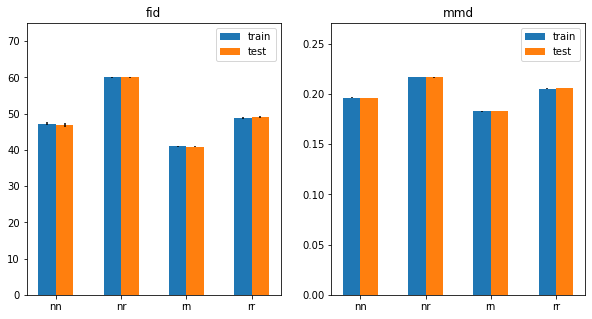

In [76]:
plot(0.4, results, save_plot=True)

In [7]:
mrr = 0.3
results_ = {}

gss = {
    'nn': config_gs(0, pretrained_gen_paths['0']),
    'nr': config_gs(mrr, pretrained_gen_paths['0']),
    'rn': config_gs(0, pretrained_gen_paths[str(mrr)]),
    'rr': config_gs(mrr, pretrained_gen_paths[str(mrr)]),
}

for mode in ['train', 'test']:
    results_[mode] = {}
    for var, gs in gss.items():
        results_[mode][var] = repeat_and_accu(gs)

results[mrr] = results_
torch.cuda.empty_cache()

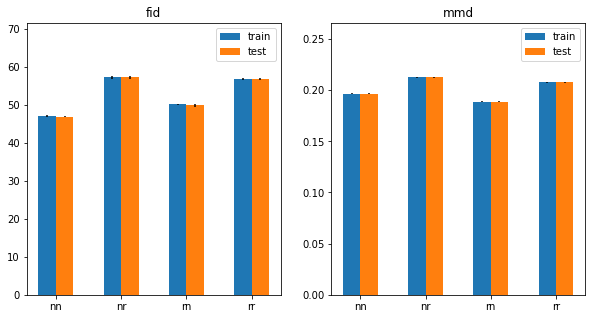

In [9]:
plot(0.3, results, save_plot=True)

In [2]:
%cat ../wgan_gp_mrr.py

import argparse
import os
import numpy as np
import math
import sys
from datetime import datetime
import time
import yaml

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

from tensorboardX import SummaryWriter
from torchsummary import summary

from fid.inception import InceptionV3
from fid.fid_score import calculate_frechet_distance
from build_dataset_fid_stats import get_stats
from utils import mask_gpu, seed_everything
from wgan_gp import Generator, Discriminator, GeneratorMRSampler, compute_gradient_penalty

class GeneratorMRRSampler(GeneratorMRSampler):
    def __init__(self, generator, mrr, latent_dim, device, real_features, 
                 proj_model=None, bsize=64, normalize=True):
        self.mrr = mrr
        self.eff